In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from pandas import Series
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid
from datetime import datetime
from Data import Data
import seaborn as sns
import itertools
from collections import Counter
import pickle
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
class_dic = load_obj("class_dic")

In [3]:
def deseasonalize_avg_std(data,freq=12):
    """
    The shape of data should be (time, index) 
    """
    n  = data.shape[1]
    N  = data.shape[0]
    data_deseasonal = np.zeros(data.shape)
    Avgs = np.zeros((n,freq))
    Stds = np.zeros((n,freq))
    for i in range(n):
        temp = np.copy(data[:,i])
        temp = np.ravel(temp)
        r = np.zeros((N))
        for j in range(freq):
            Idx = np.arange(j,N,freq)
            if temp[Idx].std() == 0:
                r[Idx] = 0
            else:
                r[Idx] = (temp[Idx] - temp[Idx].mean())/temp[Idx].std()
            Avgs[i,j] = temp[Idx].mean()
            Stds[i,j] = temp[Idx].std()
        data_deseasonal[:,i] = np.copy(r)       
    return(data_deseasonal, Avgs, Stds)

In [4]:
def southern_season(data,s_index,n=6):
    data = pd.DataFrame(data)
    n_index = ~s_index
    data_south = pd.concat([data.iloc[s_index,n:].transpose(),data.iloc[s_index,:n].transpose()],ignore_index=True,sort=False, axis=0)
    data_north = data.iloc[n_index,:]
    data_south = data_south.transpose()
    d = pd.concat([data_north,data_south],ignore_index=False,sort=False, axis=1)
    d.iloc[s_index,:n*2] = d.iloc[s_index,n*2:]
    d.columns = list(np.arange(n*4))
    d = d.drop(d.columns[list(np.arange(n*2,n*4))], axis = 1)
    return(d)

In [5]:
def Ctype(Thot, Tmon10):
    if Thot >= 22:
        return('a')
    elif Tmon10 >= 4:
        return('b')
    elif (Tmon10 >= 1) and (Tmon10 < 4):
        return('c')

def Dtype(Thot, Tmon10, Tcold):
    if Thot >= 22:
        return('a')
    elif Tmon10 >= 4:
        return('b')
    elif (Tcold < -38):
        return('d')
    else:
        return('c')

def koppen_finder(data):

    pre = data[:12]
    air = data[12:]
    
    MAP = pre.sum()
    Pdry = pre.min()
    Pwinter = pre[:6].sum()
    Psummer = pre[6:].sum()
    Pwdry = Pwinter.min()
    Psdry = Psummer.min()
    Pwwet = Pwinter.max()
    Pswet = Psummer.max()


    MAT = air.mean()
    Tcold = air.min()
    Thot = air.max()
    Tmon10 = np.count_nonzero(air > 10)

    if Pwinter >= 0.7 * MAP:
        Pthresh = 2 * MAT
    elif Psummer >= 0.7 * MAP:
        Pthresh = 2 * MAT + 28 
    else:
        Pthresh = 2 * MAT + 14

    if MAP < 10 * Pthresh:
        if MAP < 5 * Pthresh:
            if MAT >= 18:
                return('BWh')
            else:
                return('BWk')
        else:
            if MAT >= 18:
                return('BSh')
            else:
                return('BSk')
        
    elif Tcold >= 18:
        if Pdry >= 60:
            return('Af')
        elif Pdry >= (100 - (MAP/25)):
            return('Am')
        else:
            return('Aw')
        
    elif Thot < 10:
        if Thot > 0:
            return('ET')
        else:
            return('EF')
      
    elif (Thot > 10) and (Tcold <18) and (Tcold > 0):
        if (Psdry < 40) and (Psdry < Pwwet/3):
            return('Cs{}'.format(Ctype(Thot, Tmon10)))          
        elif Pwdry < Pswet/10:
            return('Cw{}'.format(Ctype(Thot, Tmon10)))  
        else:
            return('Cf{}'.format(Ctype(Thot, Tmon10))) 
        
    elif (Thot > 10) and (Tcold <=0):
        if (Psdry < 40) and (Psdry < Pwwet/3):
            return('Ds{}'.format(Dtype(Thot, Tmon10, Tcold)))           
        elif Pwdry < Pswet/10:
            return('Dw{}'.format(Dtype(Thot, Tmon10, Tcold))) 
        else:
            return('Df{}'.format(Dtype(Thot, Tmon10, Tcold)))

    else:
        return('NAN')

In [6]:
df["clusters"] = climate

NameError: name 'climate' is not defined

In [26]:
col_index = np.array([False, False, True])
index = (df.lats > 36) & (df.lons < -0.4).values
df.loc[index, col_index] = np.nan

index = (df.lats > 12) & (df.lons > 44) &(df.lons < 49).values
df.loc[index, col_index] = np.nan

index = (df.lats > 34) & (df.lons > 11.55).values
df.loc[index, col_index] = np.nan

index = (df.lats > 18) & (df.lons > 40).values
df.loc[index, col_index] = np.nan

index = (df.lats > 19) & (df.lons > 38).values
df.loc[index, col_index] = np.nan

index = (df.lats > 24) & (df.lons > 35.5).values
df.loc[index, col_index] = np.nan

index = (df.lats > 15) & (df.lons > 41.5).values
df.loc[index, col_index] = np.nan

index = (df.lats > 13.5) & (df.lons > 43).values
df.loc[index, col_index] = np.nan

index = (df.lats > 27) & (df.lons > 34.97).values
df.loc[index, col_index] = np.nan

index = (df.lats > 27.7) & (df.lons > 33.68).values
df.loc[index, col_index] = np.nan

index = df.clusters == 'nan'
df.loc[index, col_index] = np.nan

In [27]:
I = np.where(~pd.isna(df.clusters.values))[0]

In [152]:
df_af = df.iloc[I,:]

In [7]:
start_year = np.arange(1901,1996,5)
end_year = np.arange(1930,2025,5)
mid_year = np.arange(1915,2010,5)

spatial_limits={"lon_min":-23.75,"lon_max":58.75,"lat_min":-38.75,"lat_max":38.75}

In [8]:
all_climates = []

In [9]:
temporal_limits = {"time_min":datetime(start_year[0], 1, 16, 0, 0),"time_max":datetime(end_year[0], 12, 16, 0, 0)}
d = Data('./nc/cru_ts4.05.1901.2020.pre.dat.nc','pre',temporal_limits,spatial_limits, missing_value=9.96921e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lons = d.get_lon()
lats = d.get_lat()

index = np.where(result[0,:] != 9.96921e+36)[1]

result = result[:,index]
lon_list = np.array(lon_list)[index]
lat_list = np.array(lat_list)[index]

df = pd.DataFrame({"lons":lon_list,"lats":lat_list})

lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"] = lon_temp


In [8]:
xyz = -1

In [9]:
    temporal_limits = {"time_min":datetime(start_year[xyz], 1, 16, 0, 0),"time_max":datetime(end_year[xyz], 12, 16, 0, 0)}
    d = Data('./nc/cru_ts4.05.1901.2020.pre.dat.nc','pre',temporal_limits,spatial_limits, missing_value=9.96921e+36)

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    index = np.where(result[0,:] != 9.96921e+36)[1]

    result = result[:,index]
    lon_list = np.array(lon_list)[index]
    lat_list = np.array(lat_list)[index]

    d = Data('./nc/cru_ts4.05.1901.2020.tmp.dat.nc','tmp',temporal_limits,spatial_limits, missing_value=9.96921e+36)

    result_air = d.get_data()
    lon_list_air = d.get_lon_list()
    lat_list_air = d.get_lat_list()
    lon_air = d.get_lon()
    lat_air = d.get_lat()

    index = np.where(result_air[0,:] != 9.96921e+36)[1]

    result_air = result_air[:,index]
    lon_list_air = np.array(lon_list_air)[index]
    lat_list_air = np.array(lat_list_air)[index]
    
    pre_list = list(zip(lon_list,lat_list))
    air_list = list(zip(lon_list_air,lat_list_air))

    precipitation = result.copy()
    temperature = result_air.copy()

    #precipitation = precipitation/precipitation.std()
    #temperature = temperature/temperature.std()
    #D = D/D.std()

    precipitation, avgs_pre, stds_pre = deseasonalize_avg_std(precipitation)
    temperature, avgs_air, stds_air = deseasonalize_avg_std(temperature)

    avgs_pre = pd.DataFrame(avgs_pre)
    avgs_air = pd.DataFrame(avgs_air)

    df = pd.DataFrame({"lons":lon_list,"lats":lat_list})

    lon_temp = df["lons"].values
    lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
    df["lons"] = lon_temp

    s_index = (df["lats"] <= 0).values
    n_index = (df["lats"] > 0).values

    avgs_pre = southern_season(avgs_pre,s_index)
    avgs_air = southern_season(avgs_air,s_index)
      
    avgs_pre = pd.concat([avgs_pre.iloc[:,9:],avgs_pre.iloc[:,:9]],ignore_index=True,sort=False, axis=1)
    avgs_air = pd.concat([avgs_air.iloc[:,9:],avgs_air.iloc[:,:9]],ignore_index=True,sort=False, axis=1)

    data = pd.concat([avgs_pre.transpose(),avgs_air.transpose()],ignore_index=True,sort=False, axis=0)
    data = data.transpose()

In [10]:
data.shape

(12952, 24)

In [11]:
df

,lons,lats
0,-23.75,14.75
1,-23.75,15.25
2,-23.25,14.75
3,-23.25,15.25
4,-23.25,16.75
...,...,...
12947,58.75,36.75
12948,58.75,37.25
12949,58.75,37.75
12950,58.75,38.25


In [13]:
df[(df.lats == 1.75) & (df.lons == 20.25)]

,lons,lats
5502,20.25,1.75


In [15]:
data.shape

(12952, 24)

In [25]:
koppen_finder(data.iloc[5502,:].values)

'Am'

In [ ]:
2 * MAT + 14

In [42]:
2*data.iloc[5502,:].values[12:].mean()+14

65.22278054555258

In [41]:
data.iloc[5502,:].values[:12].sum()*0.7

1192.9423503875732

In [39]:
data.iloc[5502,:].values[:6].sum()

730.2899971008301

In [40]:
data.iloc[5502,:].values[6:12].sum()

973.9133605957031

In [34]:
data.iloc[5502,:].values[12:]

array([25.12666702, 25.3200016 , 25.61000443, 25.51666641, 26.30333519,
       26.50333595, 26.34000015, 26.08333397, 25.45666695, 24.95000076,
       25.04000282, 25.08666801])

In [33]:
for i, j in zip(data.iloc[5502,:].values[:12], data.iloc[5502,:].values[12:]):
    print(i,j)

210.82000732421875 25.126667022705078
145.2233428955078 25.32000160217285
86.80664825439453 25.610004425048828
51.68333053588867 25.516666412353516
88.44999694824219 26.303335189819336
147.30667114257812 26.50333595275879
167.00665283203125 26.34000015258789
165.2966766357422 26.08333396911621
132.78668212890625 25.456666946411133
153.09666442871094 24.950000762939453
167.0166778564453 25.040002822875977
188.7100067138672 25.086668014526367


In [16]:
for xyz in range(len(start_year)):
    temporal_limits = {"time_min":datetime(start_year[xyz], 1, 16, 0, 0),"time_max":datetime(end_year[xyz], 12, 16, 0, 0)}
    d = Data('./nc/cru_ts4.05.1901.2020.pre.dat.nc','pre',temporal_limits,spatial_limits, missing_value=9.96921e+36)

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    index = np.where(result[0,:] != 9.96921e+36)[1]

    result = result[:,index]
    lon_list = np.array(lon_list)[index]
    lat_list = np.array(lat_list)[index]

    d = Data('./nc/cru_ts4.05.1901.2020.tmp.dat.nc','tmp',temporal_limits,spatial_limits, missing_value=9.96921e+36)

    result_air = d.get_data()
    lon_list_air = d.get_lon_list()
    lat_list_air = d.get_lat_list()
    lon_air = d.get_lon()
    lat_air = d.get_lat()

    index = np.where(result_air[0,:] != 9.96921e+36)[1]

    result_air = result_air[:,index]
    lon_list_air = np.array(lon_list_air)[index]
    lat_list_air = np.array(lat_list_air)[index]
    
    pre_list = list(zip(lon_list,lat_list))
    air_list = list(zip(lon_list_air,lat_list_air))

    precipitation = result.copy()
    temperature = result_air.copy()

    #precipitation = precipitation/precipitation.std()
    #temperature = temperature/temperature.std()
    #D = D/D.std()

    precipitation, avgs_pre, stds_pre = deseasonalize_avg_std(precipitation)
    temperature, avgs_air, stds_air = deseasonalize_avg_std(temperature)

    avgs_pre = pd.DataFrame(avgs_pre)
    avgs_air = pd.DataFrame(avgs_air)

    df = pd.DataFrame({"lons":lon_list,"lats":lat_list})

    lon_temp = df["lons"].values
    lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
    df["lons"] = lon_temp

    s_index = (df["lats"] <= 0).values
    n_index = (df["lats"] > 0).values

    avgs_pre = southern_season(avgs_pre,s_index)
    avgs_air = southern_season(avgs_air,s_index)
      
    avgs_pre = pd.concat([avgs_pre.iloc[:,9:],avgs_pre.iloc[:,:9]],ignore_index=True,sort=False, axis=1)
    avgs_air = pd.concat([avgs_air.iloc[:,9:],avgs_air.iloc[:,:9]],ignore_index=True,sort=False, axis=1)

    data = pd.concat([avgs_pre.transpose(),avgs_air.transpose()],ignore_index=True,sort=False, axis=0)
    data = data.transpose()
     
    climate = []
    for i in range(data.shape[0]):
        climate.append(koppen_finder(data.iloc[i,:].values))

    all_climates.append(climate)

In [26]:
np.save("africa_koppen_1900_2020.npy",np.array(all_climates))

In [10]:
all_climates = np.load("africa_koppen_1900_2020.npy")

In [11]:
climate = all_climates[-1,:]

In [12]:
df["clusters"] = climate

col_index = np.array([False, False, True])
index = (df.lats > 36) & (df.lons < -0.4).values
df.loc[index, col_index] = np.nan

index = (df.lats > 12) & (df.lons > 44) &(df.lons < 49).values
df.loc[index, col_index] = np.nan

index = (df.lats > 34) & (df.lons > 11.55).values
df.loc[index, col_index] = np.nan

index = (df.lats > 18) & (df.lons > 40).values
df.loc[index, col_index] = np.nan

index = (df.lats > 19) & (df.lons > 38).values
df.loc[index, col_index] = np.nan

index = (df.lats > 24) & (df.lons > 35.5).values
df.loc[index, col_index] = np.nan

index = (df.lats > 15) & (df.lons > 41.5).values
df.loc[index, col_index] = np.nan

index = (df.lats > 13.5) & (df.lons > 43).values
df.loc[index, col_index] = np.nan

index = (df.lats > 27) & (df.lons > 34.97).values
df.loc[index, col_index] = np.nan

index = (df.lats > 27.7) & (df.lons > 33.68).values
df.loc[index, col_index] = np.nan

index = df.clusters == 'nan'
df.loc[index, col_index] = np.nan

In [13]:
I = np.where(~pd.isna(df.clusters.values))[0]

df_af = df.iloc[I,:]

In [14]:
all_climates = np.array(all_climates)

In [15]:
all_climates_af = all_climates[:,I]

In [16]:
diff = np.zeros(all_climates_af.shape[1])
old_clusters = all_climates_af[0,:].copy()
for i in range(1,all_climates_af.shape[0]):
    new_clusters = all_climates_af[i,:].copy()
    for j in range(len(new_clusters)):
        if not old_clusters[j] == new_clusters[j]:
            diff[j] = diff[j]+1
    old_clusters = all_climates_af[i,:].copy()

In [17]:
diff.max()

10.0

In [18]:
index = np.where(diff == 1)[0]

In [19]:
dic={}
for i in range(len(index)):
    a = all_climates_af[0,index[i]]
    b = all_climates_af[-1,index[i]]
    if (a,b) in dic.keys():
        dic[(a,b)]=dic[(a,b)]+1
    else:
        dic[(a,b)]=1

In [20]:
dic

{('Af', 'Am'): 20,
 ('Am', 'Af'): 14,
 ('Am', 'Aw'): 36,
 ('Aw', 'Am'): 7,
 ('Aw', 'BSh'): 63,
 ('BSh', 'Aw'): 4,
 ('BSh', 'BWh'): 55,
 ('BSh', 'Cfa'): 2,
 ('BSk', 'BSh'): 46,
 ('BSk', 'BWk'): 5,
 ('BWh', 'BSh'): 2,
 ('BWk', 'BWh'): 51,
 ('Cfa', 'Af'): 1,
 ('Cfa', 'Aw'): 34,
 ('Cfa', 'BSh'): 14,
 ('Cfa', 'BSk'): 12,
 ('Cfa', 'Cfb'): 4,
 ('Cfa', 'Cwa'): 5,
 ('Cfb', 'Af'): 2,
 ('Cfb', 'Aw'): 23,
 ('Cfb', 'BSk'): 9,
 ('Cfb', 'Cfa'): 50,
 ('Csa', 'BSh'): 1,
 ('Cwa', 'Aw'): 63,
 ('Cwa', 'BSh'): 19,
 ('Cwa', 'Cfa'): 1,
 ('Cwb', 'Cfb'): 3,
 ('Cwb', 'Cwa'): 1}

In [21]:
df_af["clusters"] = diff

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [22]:
deg = np.zeros((len(lats),len(lons)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df_af[(df_af.lats == lats[i]) & (df_af.lons == lons[j])].clusters.values.size == 0:
            deg[i,j] = df_af[(df_af.lats == lats[i]) & (df_af.lons == lons[j])].clusters.values
           # if df_af[(df_af.lats == lat[i]) & (df_af.lons == lon[j])].clusters.values == 1:
           #     deg[i,j] = 1
           # else:
           #     deg[i,j] = np.nan
        else:
            deg[i,j]=np.nan

In [23]:
import matplotlib.cm
print(matplotlib.cm.cmap_d.keys())

dict_keys(['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'magma_r', 'inferno_r', 'plasma_r', 'viridis_r', 'cividis_r', 'twilight_r', 'twilight_shifted_r', 'Blues_r', 'BrBG_r', 'BuGn_r', 'BuPu_r', 'CMRmap_r', 'GnBu_r', 'Greens_r', 

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


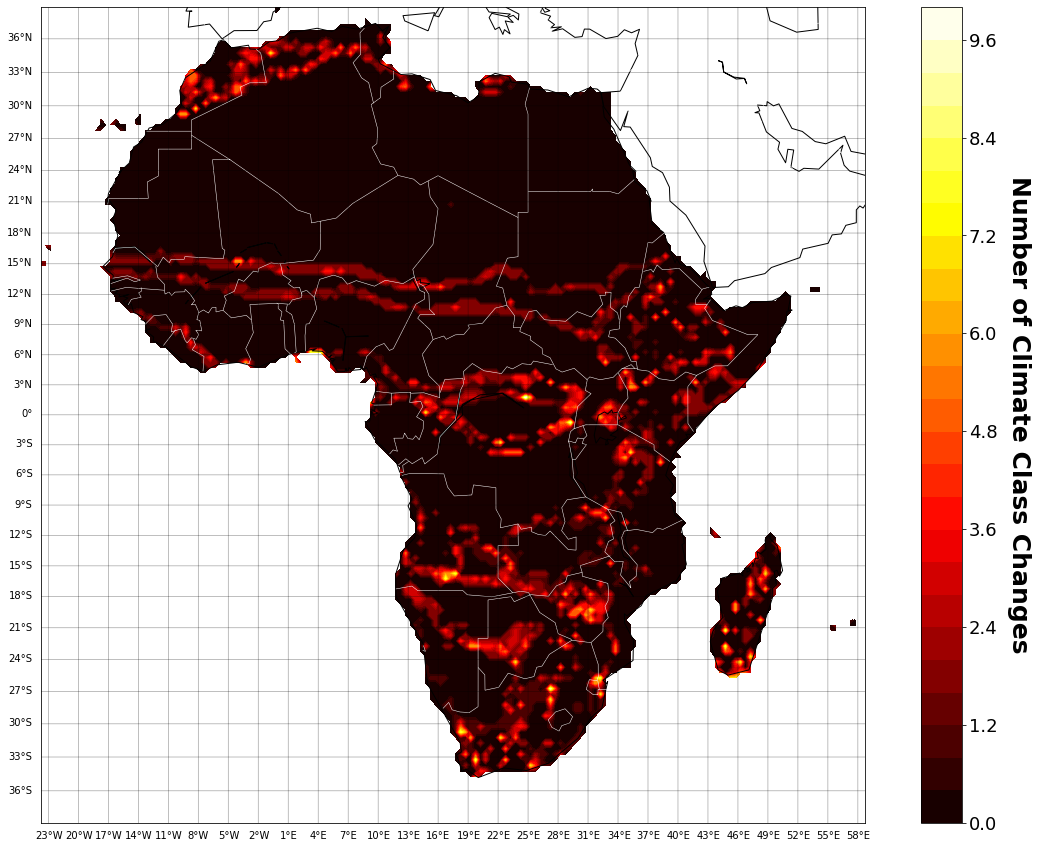

In [32]:
m=Basemap(projection='mill',lat_ts=50,llcrnrlon=lons.min(), \
  urcrnrlon=lons.max(),llcrnrlat=lats.min(),urcrnrlat=lats.max(), \
  resolution='c')
#m = Basemap(projection='ortho',lat_0=0,lon_0=-180,resolution='l')

lon2, lat2 = np.meshgrid(lons,lats)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries(color='white')
cs = m.contourf(x,y,deg,25,cmap=plt.cm.get_cmap('hot'))
#plt.colorbar()
cbar = plt.colorbar()
#cbar.ax.set_yticklabels(['0', '5', '10'])
#cbar.ax.set_yticklabels(['{:.0f}'.format(x) for x in np.arange(0, 11, 1)], fontsize=12)
cbar.set_label('Number of Climate Class Changes', rotation=270,labelpad=33, size=25,weight='bold')
cbar.ax.tick_params(labelsize=18)
#plt.title(' EOF {}'.format(pc), fontsize = 20)
plt.savefig("NumberClimateClassChanges.png")

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


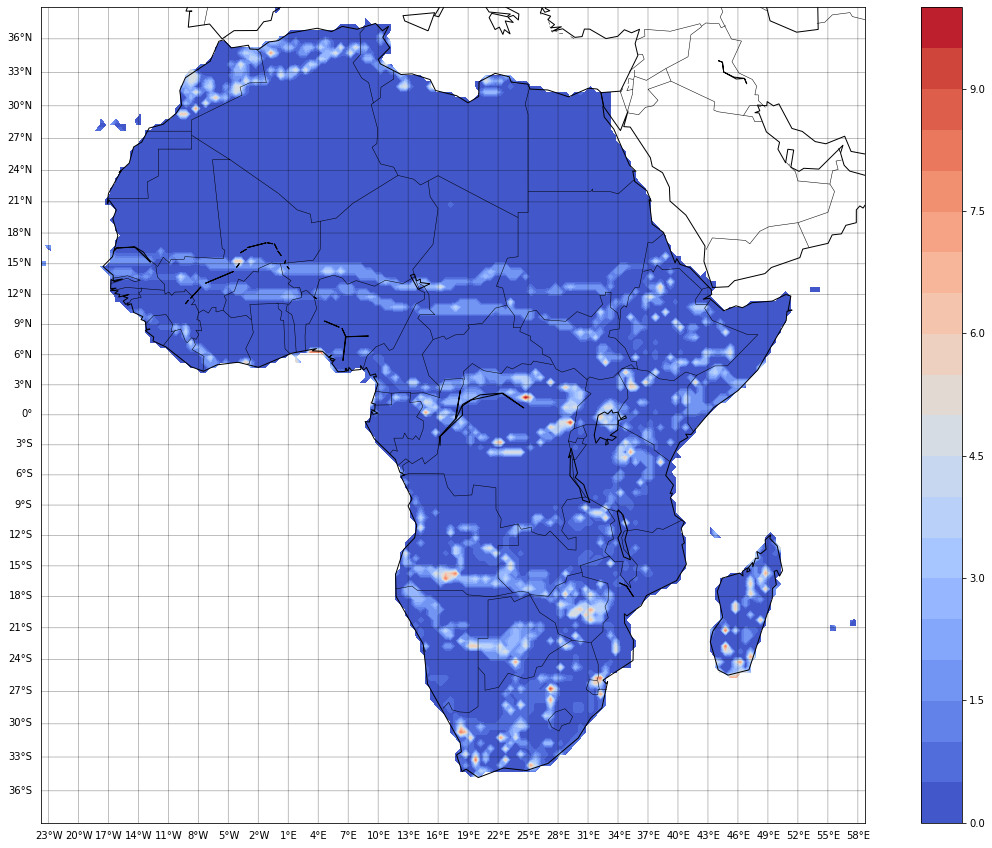

In [40]:
m=Basemap(projection='mill',lat_ts=50,llcrnrlon=lons.min(), \
  urcrnrlon=lons.max(),llcrnrlat=lats.min(),urcrnrlat=lats.max(), \
  resolution='c')
#m = Basemap(projection='ortho',lat_0=0,lon_0=-180,resolution='l')

lon2, lat2 = np.meshgrid(lons,lats)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries()
cs = m.contourf(x,y,deg,20,cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar();
#plt.title(' EOF {}'.format(pc), fontsize = 20)
#plt.savefig("Ditnace from {} within {}.png".format(class_name, class_name))

In [20]:
all_climates_af_major = np.empty(all_climates_af.shape, dtype="<U10")

In [21]:
for i in range(all_climates_af.shape[0]):
    for j in range(all_climates_af.shape[1]):
        all_climates_af_major[i,j] = all_climates_af[i,j][0]

In [22]:
diff = np.zeros(all_climates_af_major.shape[1])
old_clusters = all_climates_af_major[0,:].copy()
for i in range(1,all_climates_af_major.shape[0]):
    new_clusters = all_climates_af_major[i,:].copy()
    for j in range(len(new_clusters)):
        if not old_clusters[j] == new_clusters[j]:
            diff[j] = diff[j]+1
    old_clusters = all_climates_af_major[i,:].copy()

In [23]:
diff.max()

9.0

In [24]:
index = np.where(diff == 1)[0]

dic={}
for i in range(len(index)):
    a = all_climates_af_major[0,index[i]]
    b = all_climates_af_major[-1,index[i]]
    if (a,b) in dic.keys():
        dic[(a,b)]=dic[(a,b)]+1
    else:
        dic[(a,b)]=1

dic


{('A', 'B'): 63, ('B', 'A'): 4, ('B', 'C'): 2, ('C', 'A'): 160, ('C', 'B'): 68}

In [2]:
63/3388

0.01859504132231405

In [3]:
4/6105

0.0006552006552006552

In [4]:
68/1169

0.058169375534645

In [5]:
160/1169

0.13686911890504705

In [6]:
68/1169

0.058169375534645

In [133]:
df_af = df_af.reset_index()

In [134]:
results = []
for i in range(len(index)):
    a = all_climates_af_major[0,index[i]]
    b = all_climates_af_major[-1,index[i]]
    if a == 'C' and b == 'B':
        results.append(index[i])

In [135]:
df_af = df_af.drop('index',1)

In [92]:
all_climates_af_major.shape

(19, 10662)

In [37]:
dist_C_B = []
for i in range(len(index)):
    temp = all_climates_af_major[:,index[i]]
    for j in range(1,len(temp)):
        if temp[j-1] == 'C' and temp[j]=='B':
            dist_C_B.append(end_year[j])
            break

In [38]:
dist_C_B = np.array(dist_C_B)

np.count_nonzero(dist_C_B >= 1980)/len(dist_C_B)

0.8823529411764706

In [25]:
dist_A_B = []
for i in range(len(index)):
    temp = all_climates_af_major[:,index[i]]
    for j in range(1,len(temp)):
        if temp[j-1] == 'A' and temp[j]=='B':
            dist_A_B.append(end_year[j])
            break

In [30]:
dist_A_B = np.array(dist_A_B)

In [36]:
np.count_nonzero(dist_A_B >= 1980)/len(dist_A_B)

0.9682539682539683

In [39]:
dist_C_A = []
for i in range(len(index)):
    temp = all_climates_af_major[:,index[i]]
    for j in range(1,len(temp)):
        if temp[j-1] == 'C' and temp[j]=='A':
            dist_C_A.append(end_year[j])
            break

In [40]:
dist_C_A = np.array(dist_C_A)

np.count_nonzero(dist_C_A >= 1980)/len(dist_C_A)

0.775

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


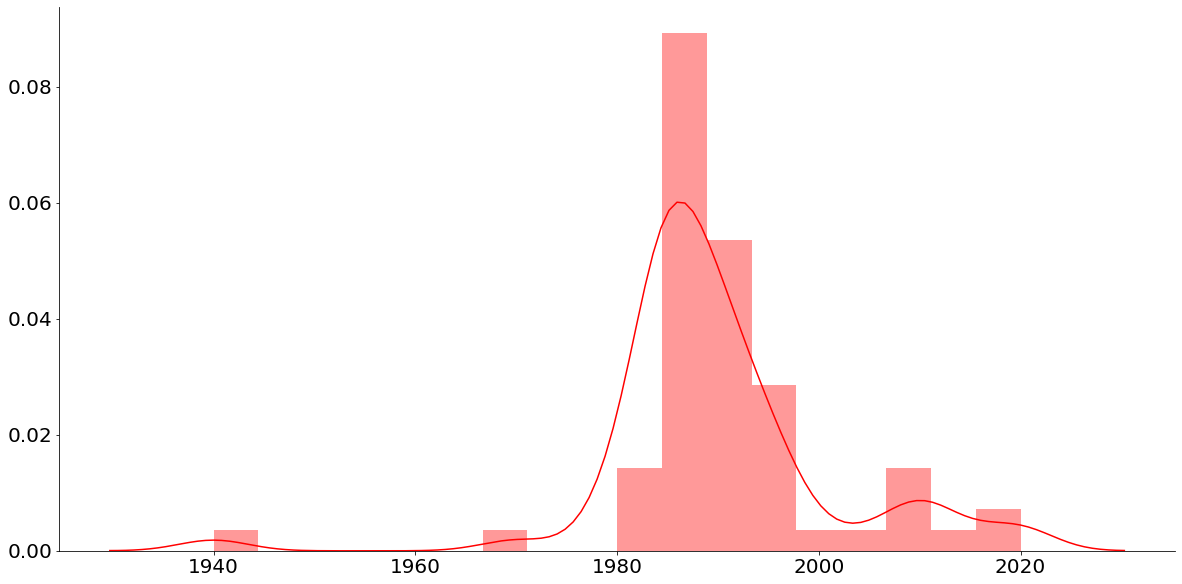

In [29]:
sns.distplot(dist_A_B, bins=18, color='r')
#fig = plt.figure(figsize = (15,10))
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
axes = plt.gca()
#axes.set_xlim([1935,2020])
#plt.savefig("ClimteShiftsDist.png")

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


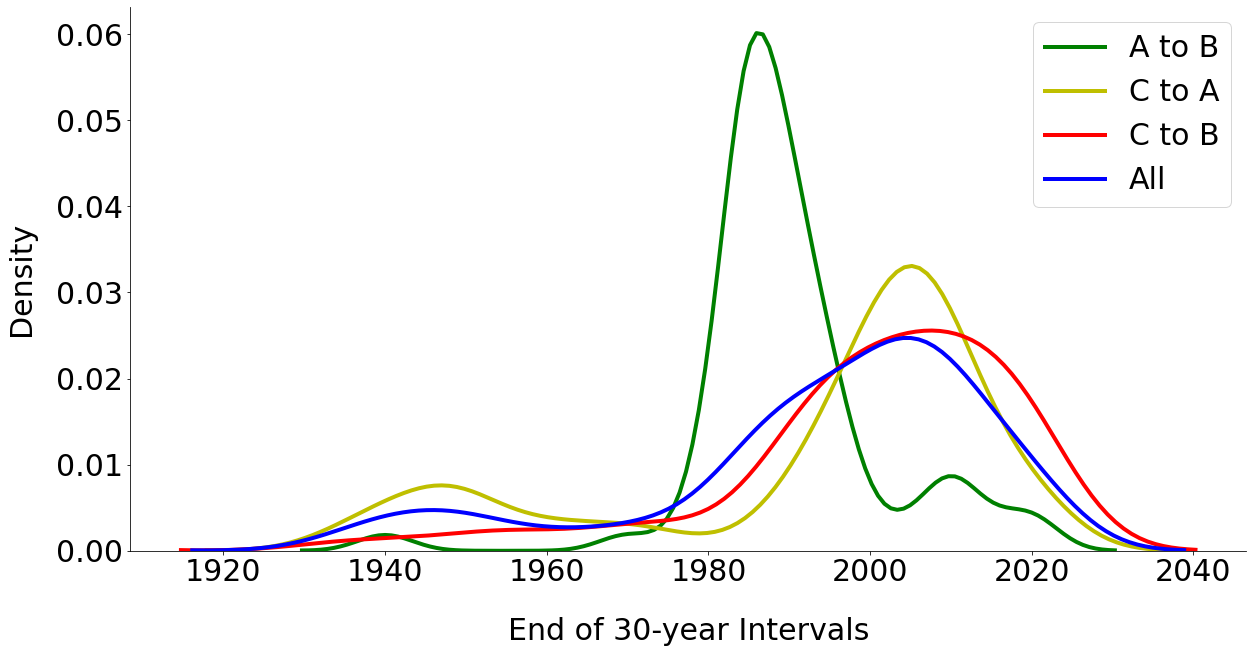

In [132]:
sns.distplot(dist_A_B, bins=18, color='g', hist=False , label="A to B",kde_kws=dict(linewidth=4))
sns.distplot(dist_C_A, bins=18, color='y', hist=False , label="C to A",kde_kws=dict(linewidth=4))
sns.distplot(dist_C_B,bins=18, color='r', hist=False, label="C to B",kde_kws=dict(linewidth=4))
sns.distplot(dist, bins=18, color='b', hist=False, label='All',kde_kws=dict(linewidth=4))
#fig = plt.figure(figsize = (15,10))
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)
ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
axes = plt.gca()
#plt.axvline(1980, color = 'r',linewidth = 2)
plt.legend(fontsize=30)
plt.xlabel("End of 30-year Intervals", fontsize = 30,labelpad = 30)
plt.ylabel("Density", fontsize = 30,labelpad = 20)
#axes.set_xlim([1935,2020])
plt.savefig("ClimteShiftsDist.png")

In [41]:
dist = []
for i in range(len(index)):
    temp = all_climates_af_major[:,index[i]]
    for j in range(1,len(temp)):
        if not temp[j-1] == temp[j]:
            dist.append(end_year[j])
            break

In [42]:
dist = np.array(dist)

np.count_nonzero(dist >= 1980)/len(dist)

0.835016835016835

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


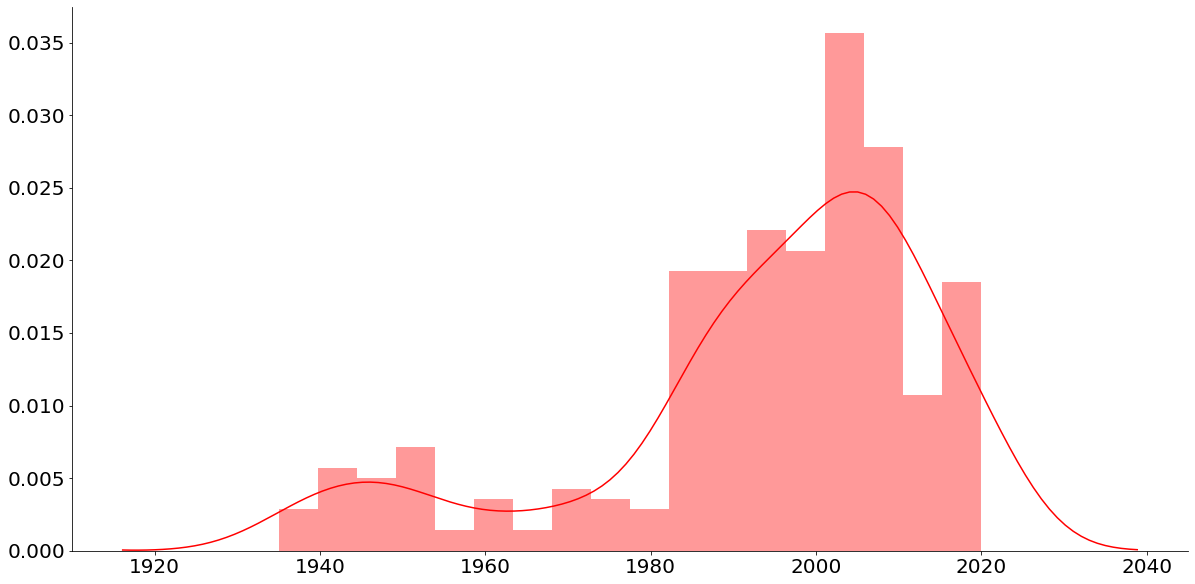

In [74]:
sns.distplot(dist, bins=18, color='r')
#fig = plt.figure(figsize = (15,10))
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
axes = plt.gca()
#axes.set_xlim([1935,2020])
plt.savefig("ClimteShiftsDist.png")

In [43]:
dist = pd.DataFrame(dist)

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9af04bdc50>],
      dtype=object)

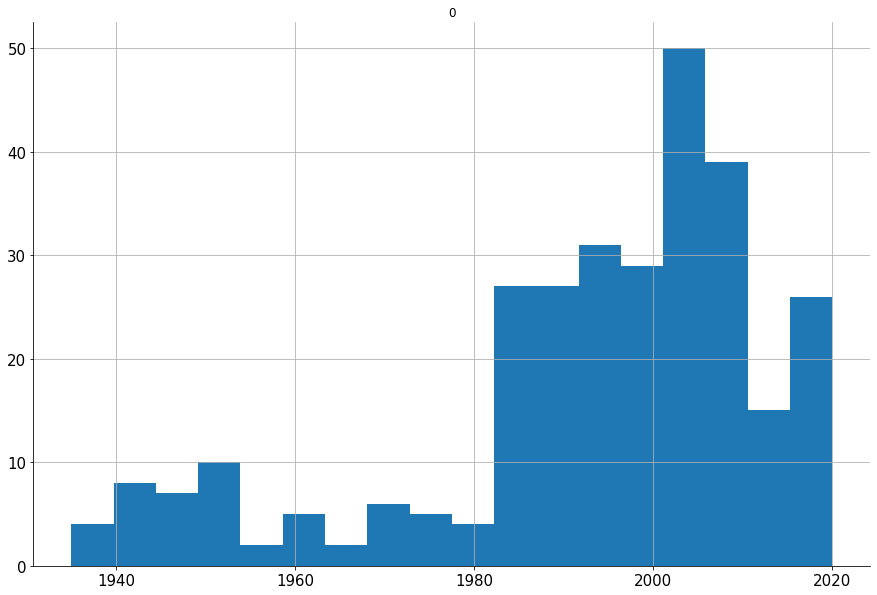

In [53]:
fig = plt.figure(figsize = (15,10))
ax = fig.gca()
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
axes = plt.gca()
dist.hist(ax = ax, bins=18)

In [107]:
end_year[15]

2005

In [79]:
df_temp = df_af.loc[results,:]

In [80]:
df_temp

,lons,lats,clusters
12,-17.75,27.75,1.0
822,-7.75,32.75,1.0
824,-7.75,33.75,1.0
1188,-4.75,32.75,1.0
1251,-4.25,33.75,1.0
...,...,...,...
7978,30.25,-16.75,1.0
8209,31.25,-25.25,1.0
8465,32.25,-19.25,4.0
8469,32.25,-17.25,1.0


/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':


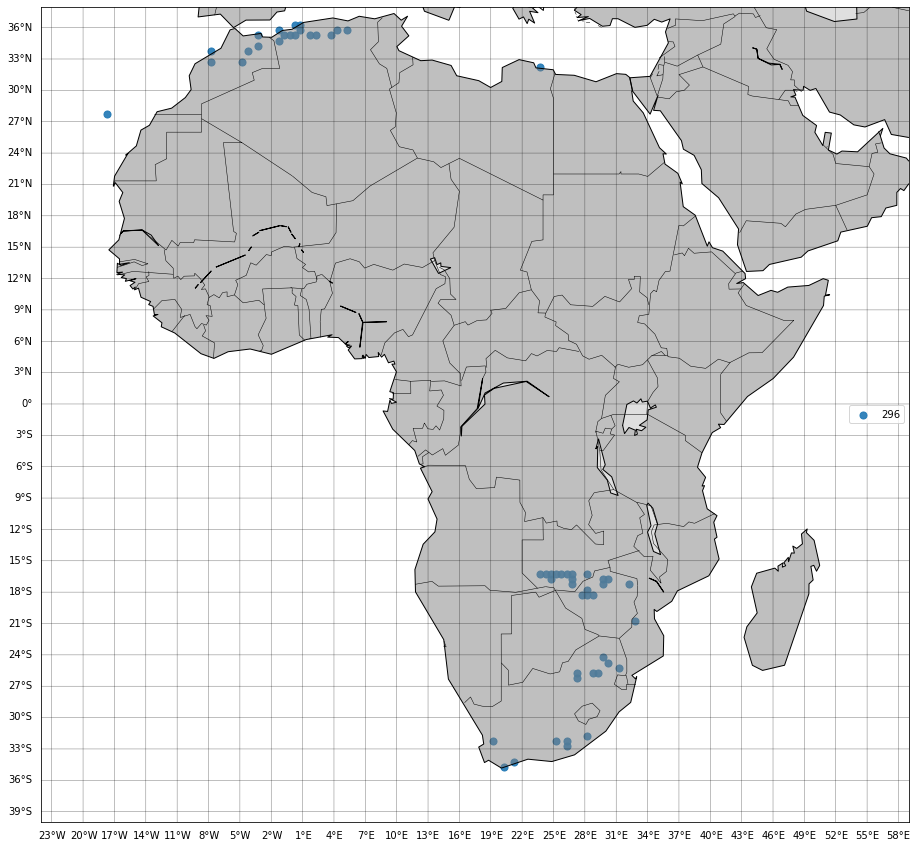

In [81]:
fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=59,urcrnrlat=38)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries()
#colors = pf.random_color_1(n_components)


values = df_temp["clusters"].values  
Idx = np.where(values == 1)[0]
#df_list[i] = df.iloc[Idx,:]
#df_list[i]["values"] = values[Idx]

lons = df_temp.iloc[Idx,0].values
lats = df_temp.iloc[Idx,1].values
x,y = m(lons, lats)
ax.scatter(x, y, alpha=0.9, s=50, label = i)

    
#plt.title("Clustering, {} - {}".format(start_year, end_year), fontsize = 20)     
plt.legend()
#plt.savefig("start end diff 3var.png")
plt.show()

In [63]:
all_climates_af_major[:,9893]

array(['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'B'], dtype='<U10')

In [1]:
63/3388

0.01859504132231405

In [79]:
68/1169

0.058169375534645

In [80]:
160/1169

0.13686911890504705

In [75]:
np.count_nonzero(all_climates_af_major[0,:] == 'A')

3388

In [77]:
np.count_nonzero(all_climates_af_major[0,:] == 'C')

1169

In [78]:
np.count_nonzero(all_climates_af_major[0,:] == 'B')

6105

In [ ]:
df_af["clusters"] = diff

deg = np.zeros((len(lat),len(lon)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df_af[(df_af.lats == lat[i]) & (df_af.lons == lon[j])].clusters.values.size == 0:
            deg[i,j] = df_af[(df_af.lats == lat[i]) & (df_af.lons == lon[j])].clusters.values
           # if df_af[(df_af.lats == lat[i]) & (df_af.lons == lon[j])].clusters.values == 1:
           #     deg[i,j] = 1
           # else:
           #     deg[i,j] = np.nan
        else:
            deg[i,j]=np.nan

m=Basemap(projection='mill',lat_ts=50,llcrnrlon=lon.min(), \
  urcrnrlon=lon.max(),llcrnrlat=lat.min(),urcrnrlat=lat.max(), \
  resolution='c')
#m = Basemap(projection='ortho',lat_0=0,lon_0=-180,resolution='l')

lon2, lat2 = np.meshgrid(lon,lat)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries()
cs = m.contourf(x,y,deg,20,cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar();
#plt.title(' EOF {}'.format(pc), fontsize = 20)
#plt.savefig("Ditnace from {} within {}.png".format(class_name, class_name))

In [56]:
segment = 0

In [57]:
df["clusters"] = all_climates[segment,:]

In [58]:
col_index = np.array([False, False, True])
index = (df.lats > 36) & (df.lons < -0.4).values
df.loc[index, col_index] = np.nan

index = (df.lats > 12) & (df.lons > 44) &(df.lons < 49).values
df.loc[index, col_index] = np.nan

index = (df.lats > 34) & (df.lons > 11.55).values
df.loc[index, col_index] = np.nan

index = (df.lats > 18) & (df.lons > 40).values
df.loc[index, col_index] = np.nan

index = (df.lats > 19) & (df.lons > 38).values
df.loc[index, col_index] = np.nan

index = (df.lats > 24) & (df.lons > 35.5).values
df.loc[index, col_index] = np.nan

index = (df.lats > 15) & (df.lons > 41.5).values
df.loc[index, col_index] = np.nan

index = (df.lats > 13.5) & (df.lons > 43).values
df.loc[index, col_index] = np.nan

index = (df.lats > 27) & (df.lons > 34.97).values
df.loc[index, col_index] = np.nan

index = (df.lats > 27.7) & (df.lons > 33.68).values
df.loc[index, col_index] = np.nan

index = df.clusters == 'nan'
df.loc[index, col_index] = np.nan

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


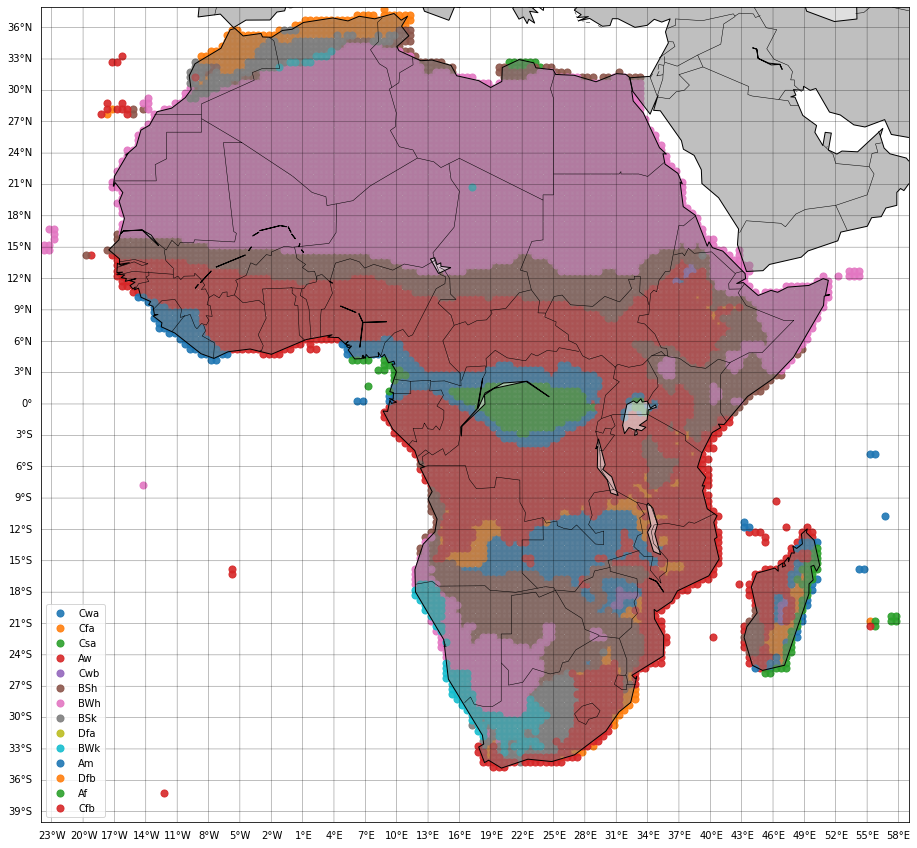

In [59]:
df_list = []
for j in range(len(set(all_climates[segment,:]))):
    df_list.append(pd.DataFrame(columns=df.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=59,urcrnrlat=38)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries()
#colors = pf.random_color_1(n_components)


i = 0
for j in set(all_climates[segment,:]):
    values = df["clusters"].values  
    Idx = np.where(values == j)[0]
    df_list[i] = df.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=50, label = j)
    i+=1
    
    
plt.legend()
#plt.savefig("6_Clusters_non_standard.png")
plt.show()

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


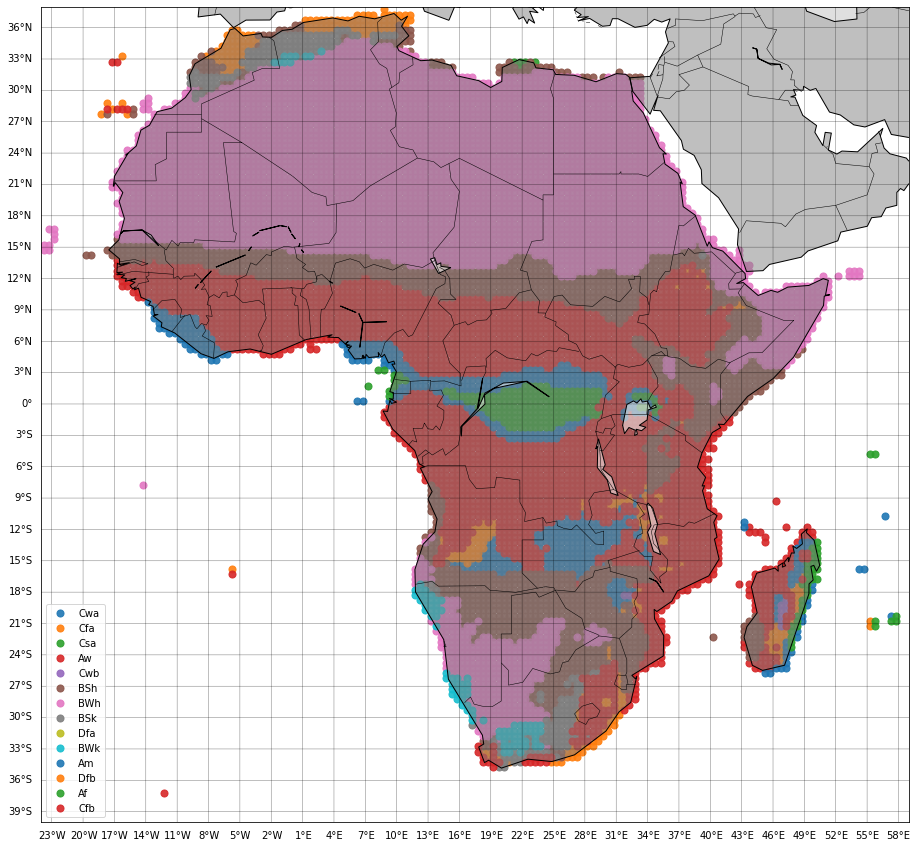

In [55]:
df_list = []
for j in range(len(set(all_climates[segment,:]))):
    df_list.append(pd.DataFrame(columns=df.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=59,urcrnrlat=38)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries()
#colors = pf.random_color_1(n_components)


i = 0
for j in set(all_climates[segment,:]):
    values = df["clusters"].values  
    Idx = np.where(values == j)[0]
    df_list[i] = df.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=50, label = j)
    i+=1
    
    
plt.legend()
#plt.savefig("6_Clusters_non_standard.png")
plt.show()

In [13]:
all_climates = np.array(all_climates)

In [44]:
df[all_climates[0,0][0]][0]

0.0

In [32]:
major_climates = ['A', 'B', 'C', 'D', 'E']

In [33]:
areas = np.zeros((19,5))
df_areas = pd.DataFrame(areas,columns=['A', 'B', 'C', 'D', 'E'])

In [28]:
all_climates.shape

(19, 12952)

In [30]:
all_climates_af = all_climates[:,I]

In [19]:
results.shape

NameError: name 'results' is not defined

In [34]:
for i in range(19):
    for j in range(all_climates_af.shape[1]):
        df_areas[all_climates_af[i,j][0]][i]+=1

In [35]:
df_areas

,A,B,C,D,E
0,3388.0,6105.0,1169.0,0.0,0.0
1,3394.0,6097.0,1171.0,0.0,0.0
2,3409.0,6077.0,1176.0,0.0,0.0
3,3437.0,6066.0,1159.0,0.0,0.0
4,3460.0,6091.0,1111.0,0.0,0.0
5,3471.0,6062.0,1129.0,0.0,0.0
6,3476.0,6032.0,1154.0,0.0,0.0
7,3482.0,6024.0,1156.0,0.0,0.0
8,3497.0,6037.0,1128.0,0.0,0.0
9,3471.0,6049.0,1142.0,0.0,0.0


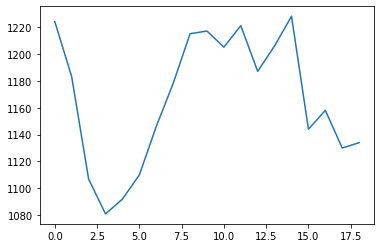

In [36]:
plt.plot(df.iloc[:,3])

In [75]:
(1550-1200)/1550

0.22580645161290322

In [36]:
df_change = df_areas.pct_change()

In [37]:
df_change.index = mid_year

In [38]:
df_change

,A,B,C,D,E
1915,NaN,NaN,NaN,NaN,NaN
1920,0.001771,-0.001310,0.001711,NaN,NaN
1925,0.004420,-0.003280,0.004270,NaN,NaN
1930,0.008214,-0.001810,-0.014456,NaN,NaN
1935,0.006692,0.004121,-0.041415,NaN,NaN
1940,0.003179,-0.004761,0.016202,NaN,NaN
1945,0.001441,-0.004949,0.022143,NaN,NaN
1950,0.001726,-0.001326,0.001733,NaN,NaN
1955,0.004308,0.002158,-0.024221,NaN,NaN
1960,-0.007435,0.001988,0.012411,NaN,NaN


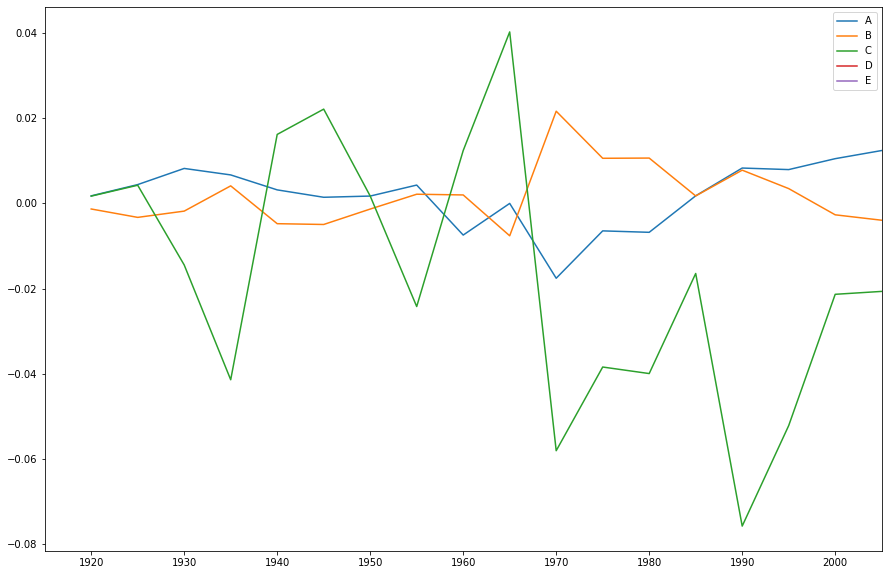

In [39]:
df_change.plot(figsize=(15,10))

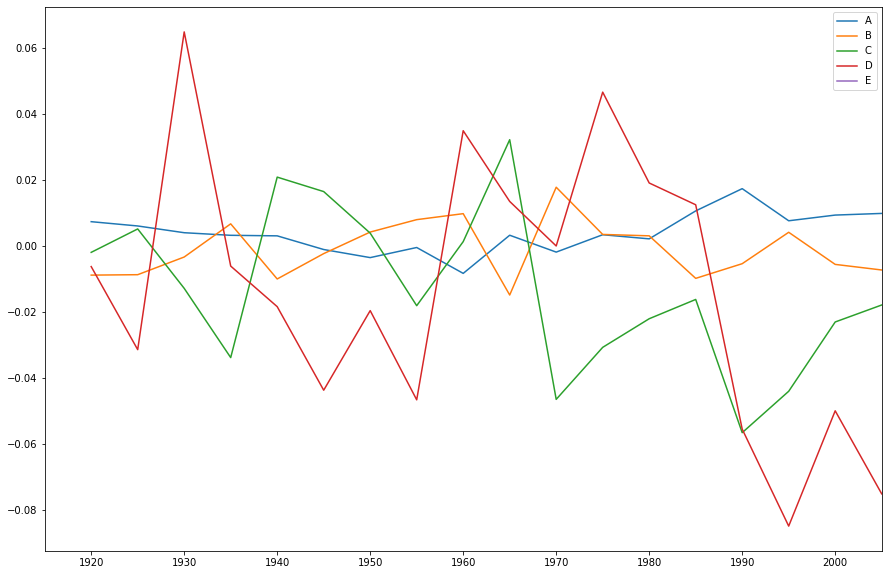

In [64]:
df_change.plot(figsize=(15,10))

In [24]:
koppen = np.load("africa_koppen_1900_2020.npy")

In [10]:
df_centroid = pd.read_csv("centroids_kottek.csv")

In [11]:
start_year = np.arange(1901,1996,5)
end_year = np.arange(1930,2025,5)
mid_year = np.arange(1915,2010,5)

spatial_limits={"lon_min":-23.75,"lon_max":58.75,"lat_min":-38.75,"lat_max":38.75}

dist= []

In [12]:
df_centroid.columns

Index(['Csc', 'As', 'ET', 'Dsc', 'Dfa', 'Csa', 'Cwc', 'Af', 'Cwa', 'Dfb',
       'BSk', 'Cfb', 'Dwb', 'Am', 'BWh', 'Dfd', 'Dwa', 'Dwc', 'Cfa', 'Dsb',
       'BSh', 'Dwd', 'Cwb', 'Dsa', 'Csb', 'Cfc', 'Aw', 'Dfc', 'EF', 'BWk'],
      dtype='object')

In [29]:
class_name = 'Csb'

In [30]:
class_data = df_centroid[class_name].values

In [31]:
for class_name in df_centroid.columns:
    class_data = df_centroid[class_name].values
    for xyz in range(len(start_year)):
        temporal_limits = {"time_min":datetime(start_year[xyz], 1, 16, 0, 0),"time_max":datetime(end_year[xyz], 12, 16, 0, 0)}
        d = Data('./nc/cru_ts4.05.1901.2020.pre.dat.nc','pre',temporal_limits,spatial_limits, missing_value=9.96921e+36)

        result = d.get_data()
        lon_list = d.get_lon_list()
        lat_list = d.get_lat_list()
        lon = d.get_lon()
        lat = d.get_lat()

        index = np.where(result[0,:] != 9.96921e+36)[1]

        result = result[:,index]
        lon_list = np.array(lon_list)[index]
        lat_list = np.array(lat_list)[index]

        d = Data('./nc/cru_ts4.05.1901.2020.tmp.dat.nc','tmp',temporal_limits,spatial_limits, missing_value=9.96921e+36)

        result_air = d.get_data()
        lon_list_air = d.get_lon_list()
        lat_list_air = d.get_lat_list()
        lon_air = d.get_lon()
        lat_air = d.get_lat()

        index = np.where(result_air[0,:] != 9.96921e+36)[1]

        result_air = result_air[:,index]
        lon_list_air = np.array(lon_list_air)[index]
        lat_list_air = np.array(lat_list_air)[index]

        pre_list = list(zip(lon_list,lat_list))
        air_list = list(zip(lon_list_air,lat_list_air))

        precipitation = result.copy()
        temperature = result_air.copy()

        #precipitation = precipitation/precipitation.std()
        #temperature = temperature/temperature.std()
        #D = D/D.std()

        precipitation, avgs_pre, stds_pre = deseasonalize_avg_std(precipitation)
        temperature, avgs_air, stds_air = deseasonalize_avg_std(temperature)

        avgs_pre = pd.DataFrame(avgs_pre)
        avgs_air = pd.DataFrame(avgs_air)

        df = pd.DataFrame({"lons":lon_list,"lats":lat_list})

        lon_temp = df["lons"].values
        lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
        df["lons"] = lon_temp

        s_index = (df["lats"] <= 0).values
        n_index = (df["lats"] > 0).values

        avgs_pre = southern_season(avgs_pre,s_index)
        avgs_air = southern_season(avgs_air,s_index)

        avgs_pre = pd.concat([avgs_pre.iloc[:,9:],avgs_pre.iloc[:,:9]],ignore_index=True,sort=False, axis=1)
        avgs_air = pd.concat([avgs_air.iloc[:,9:],avgs_air.iloc[:,:9]],ignore_index=True,sort=False, axis=1)

        data = pd.concat([avgs_pre.transpose(),avgs_air.transpose()],ignore_index=True,sort=False, axis=0)
        data = data.transpose()

        class_m = np.ones(data.T.shape)*class_data.reshape(-1,1)
        dist.append(np.sqrt(((class_m-np.array(data).T) ** 2).sum(0)))

In [ ]:
dist = np.array(dist)

np.save("dist_{}.npy".format(class_name),dist)

In [ ]:
for class_name in df_centroid.columns:
    class_data = df_centroid[class_name].values
    class_m = np.ones(data.T.shape)*class_data.reshape(-1,1)
    dist.append(np.sqrt(((class_m-np.array(data).T) ** 2).sum(0)))

25

In [13]:
class_names = df_centroid.columns
dist = np.load("./dist/dist_{}.npy".format('Af'))
data = np.zeros((dist.shape[0], dist.shape[1], len(class_names)))

In [14]:
for i in range(len(class_names)):
    dist = np.load("./dist/dist_{}.npy".format(class_names[i]))
    data[:,:,i] = dist

In [22]:
results = []
for i in range(dist.shape[0]):
    result = []
    for j in range(dist.shape[1]):
        result.append(class_names[np.argmin(data[i,j,:])])
    results.append(result)

results = np.array(results)

array([['BSh', 'BSh', 'BSh', ..., 'Dsa', 'BWk', 'BWk'],
       ['BSh', 'BSh', 'BSh', ..., 'Dsa', 'BWk', 'BWk'],
       ['BSh', 'BSh', 'BSh', ..., 'Dsa', 'BWk', 'BWk'],
       ...,
       ['BSh', 'BSh', 'BSh', ..., 'Dsa', 'BWk', 'BWk'],
       ['BSh', 'BSh', 'BSh', ..., 'Dsa', 'BWk', 'BWk'],
       ['BSh', 'BSh', 'BSh', ..., 'Dsa', 'BWk', 'BWk']], dtype='<U3')

In [25]:
koppen

array([['Aw', 'Aw', 'Aw', ..., 'BSk', 'BWk', 'BWk'],
       ['Aw', 'Aw', 'Aw', ..., 'BSk', 'BWk', 'BWk'],
       ['Aw', 'Aw', 'Aw', ..., 'BSk', 'BWk', 'BWk'],
       ...,
       ['Aw', 'Aw', 'Aw', ..., 'BSk', 'BWk', 'BWk'],
       ['Aw', 'Aw', 'Aw', ..., 'BWk', 'BWk', 'BWk'],
       ['Aw', 'Aw', 'Aw', ..., 'BSk', 'BWk', 'BWk']], dtype='<U3')

In [92]:
class_dic = load_obj("class_dic")

class_list = []
for i in range(len(lon_list)):
    lon, lat = lon_list[i], lat_list[i]
    if lon > 180: lon -= 360
    if (lat, lon) in class_dic.keys(): 
        class_list.append(class_dic[(lat, lon)])
    else:
        class_list.append(np.nan)
class_list = np.array(class_list)

In [86]:
class_name = "BWh"

#dist = np.load("dist_{}.npy".format(class_name))
dist = np.load("./dist_AF_limited_classes/dist_{}.npy".format(class_name))

In [87]:
index = (class_list == class_name)

In [88]:
np.count_nonzero(index)

5499

In [89]:
velocity = (dist[0,:] - dist[-1,:])/90
df["velocity"] = velocity

index = (class_list == class_name)
df.iloc[~index,2] = np.nan

deg = np.zeros((len(lats),len(lons)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df[(df.lats == lats[i]) & (df.lons == lons[j])].velocity.values.size == 0:
            deg[i,j] = df[(df.lats == lats[i]) & (df.lons == lons[j])].velocity.values
           # if df[(df.lats == lat[i]) & (df.lons == lon[j])].clusters.values == 1:
           #     deg[i,j] = 1
           # else:
           #     deg[i,j] = np.nan
        else:
            deg[i,j]=np.nan

In [90]:
if np.nanmax(deg) > 0 and np.nanmax(deg) > abs(np.nanmin(deg)):
    vmin = -np.nanmax(deg)
    vmax = np.nanmax(deg)
elif np.nanmin(deg) < 0 and np.nanmax(deg) < abs(np.nanmin(deg)):
    vmin = np.nanmin(deg)
    vmax = -np.nanmin(deg)
elif np.nanmax(deg) > 0 and np.nanmin(deg) > 0:
    vmin = 0
    vmax = np.nanmax(deg)
elif np.nanmax(deg) < 0 and np.nanmin(deg) < 0:
    vmin = np.nanmin(deg)
    vmax = 0

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


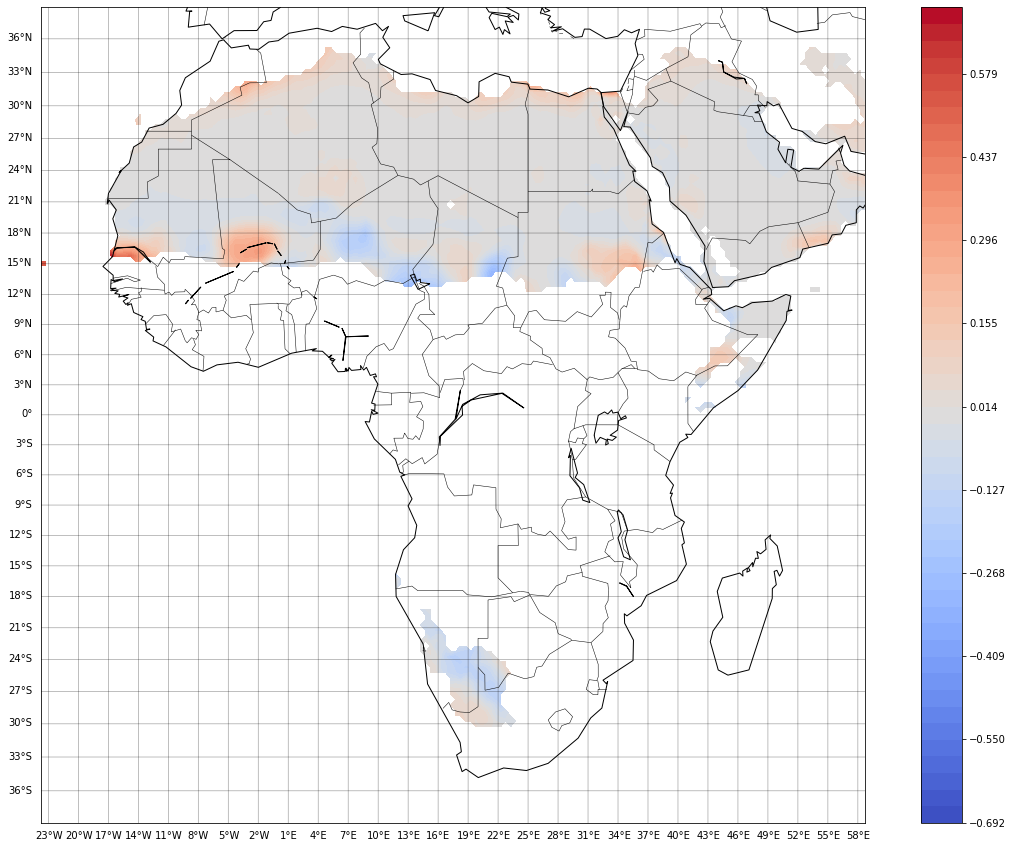

In [91]:
m=Basemap(projection='mill',lat_ts=50,llcrnrlon=lons.min(), \
  urcrnrlon=lons.max(),llcrnrlat=lats.min(),urcrnrlat=lats.max(), \
  resolution='c')
#m = Basemap(projection='ortho',lat_0=0,lon_0=-180,resolution='l')

lon2, lat2 = np.meshgrid(lons,lats)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries()

levels = np.linspace(vmin, vmax)
cs = m.contourf(x,y,deg,20, levels = levels, cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar();
#plt.title(' EOF {}'.format(pc), fontsize = 20)
#plt.savefig("Ditnace from {} within {}.png".format(class_name, class_name))

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


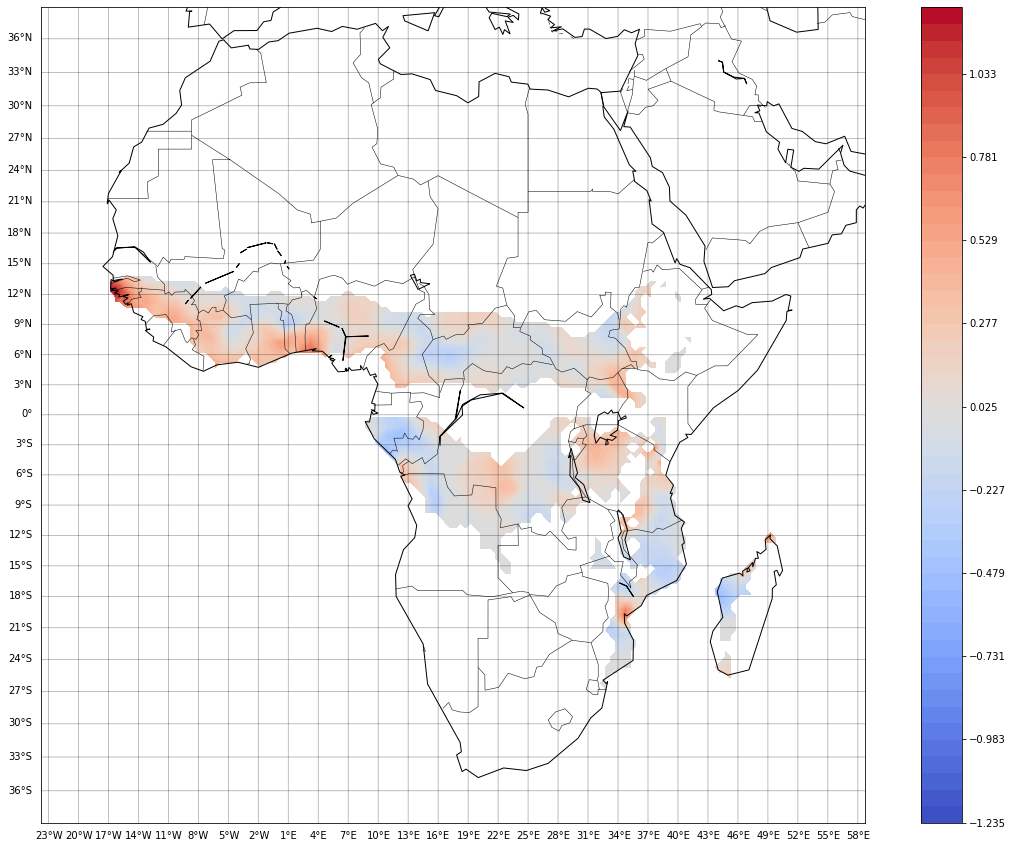

In [79]:
m=Basemap(projection='mill',lat_ts=50,llcrnrlon=lons.min(), \
  urcrnrlon=lons.max(),llcrnrlat=lats.min(),urcrnrlat=lats.max(), \
  resolution='c')
#m = Basemap(projection='ortho',lat_0=0,lon_0=-180,resolution='l')

lon2, lat2 = np.meshgrid(lons,lats)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries()

levels = np.linspace(vmin, vmax)
cs = m.contourf(x,y,deg,20, levels = levels, cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar();
#plt.title(' EOF {}'.format(pc), fontsize = 20)
#plt.savefig("Ditnace from {} within {}.png".format(class_name, class_name))

In [ ]:
velocity = (dist[0,:] - dist[-1,:])/90

df["velocity"] = velocity

index = (class_list == class_name)

df.iloc[~index,2] = np.nan

deg = np.zeros((len(lat),len(lon)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df[(df.lats == lat[i]) & (df.lons == lon[j])].velocity.values.size == 0:
            deg[i,j] = df[(df.lats == lat[i]) & (df.lons == lon[j])].velocity.values
           # if df[(df.lats == lat[i]) & (df.lons == lon[j])].clusters.values == 1:
           #     deg[i,j] = 1
           # else:
           #     deg[i,j] = np.nan
        else:
            deg[i,j]=np.nan

# Major Classses

In [120]:
class_dic = load_obj("class_dic")

class_list = []
for i in range(len(lon_list)):
    lon, lat = lon_list[i], lat_list[i]
    if lon > 180: lon -= 360
    if (lat, lon) in class_dic.keys(): 
        class_list.append(class_dic[(lat, lon)])
    else:
        class_list.append(np.nan)
class_list = np.array(class_list)

In [121]:
class_major = []
for i in range(len(class_list)):
    class_major.append(class_list[i][0])
class_major = np.array(class_major)    

In [122]:
class_name = "C"

dist = np.load("./dist_major/dist_{}.npy".format(class_name))

index = (class_major == class_name)

In [123]:
velocity = (dist[0,:] - dist[-1,:])/90
df["velocity"] = velocity

index = (class_major == class_name)
df.iloc[~index,2] = np.nan

deg = np.zeros((len(lats),len(lons)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df[(df.lats == lats[i]) & (df.lons == lons[j])].velocity.values.size == 0:
            deg[i,j] = df[(df.lats == lats[i]) & (df.lons == lons[j])].velocity.values
        else:
            deg[i,j]=np.nan

In [124]:
if np.nanmax(deg) > 0 and np.nanmax(deg) > abs(np.nanmin(deg)):
    vmin = -np.nanmax(deg)
    vmax = np.nanmax(deg)
elif np.nanmin(deg) < 0 and np.nanmax(deg) < abs(np.nanmin(deg)):
    vmin = np.nanmin(deg)
    vmax = -np.nanmin(deg)
elif np.nanmax(deg) > 0 and np.nanmin(deg) > 0:
    vmin = 0
    vmax = np.nanmax(deg)
elif np.nanmax(deg) < 0 and np.nanmin(deg) < 0:
    vmin = np.nanmin(deg)
    vmax = 0

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


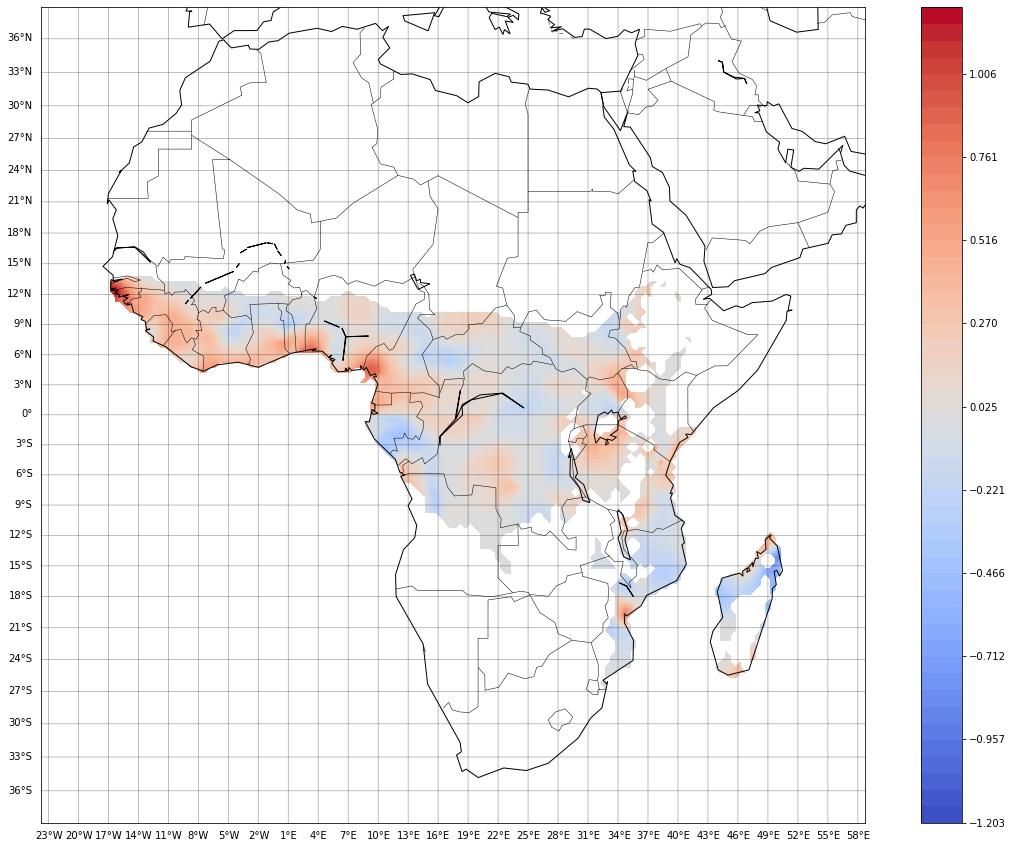

In [110]:
m=Basemap(projection='mill',lat_ts=50,llcrnrlon=lons.min(), \
  urcrnrlon=lons.max(),llcrnrlat=lats.min(),urcrnrlat=lats.max(), \
  resolution='c')
#m = Basemap(projection='ortho',lat_0=0,lon_0=-180,resolution='l')

lon2, lat2 = np.meshgrid(lons,lats)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries()

levels = np.linspace(vmin, vmax)
cs = m.contourf(x,y,deg,20, levels = levels, cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar();
#plt.title(' EOF {}'.format(pc), fontsize = 20)
#plt.savefig("Ditnace from {} within {}.png".format(class_name, class_name))

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


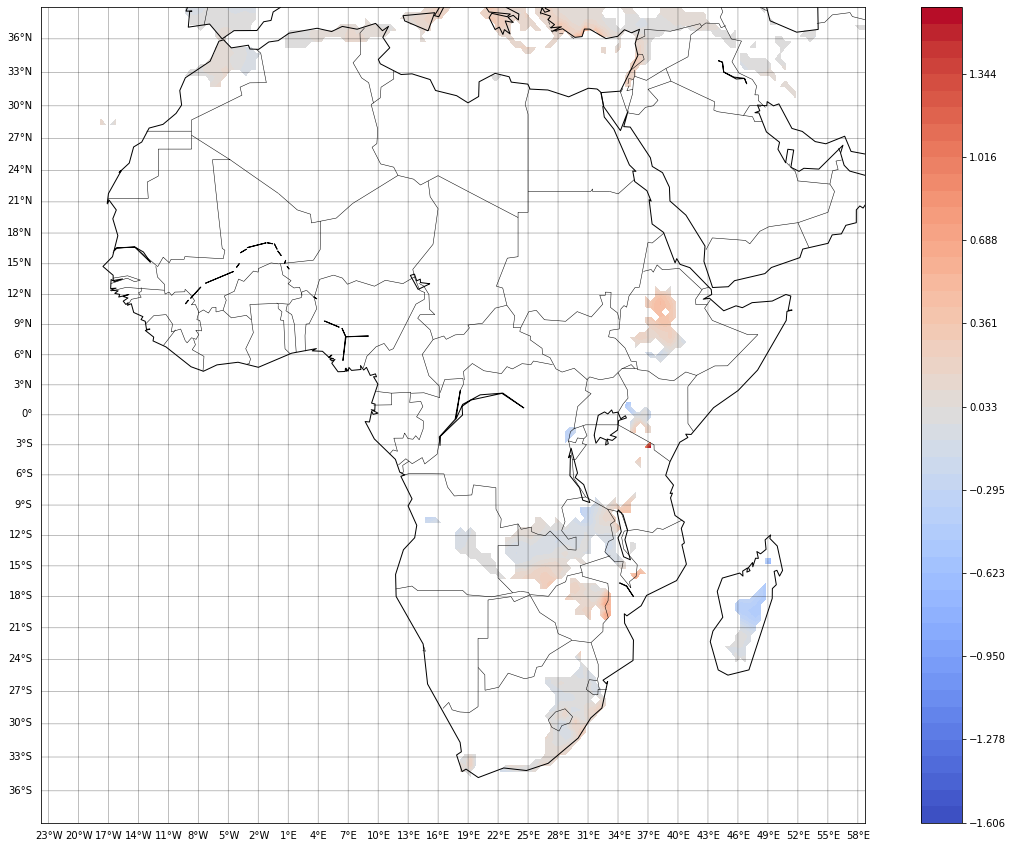

In [125]:
m=Basemap(projection='mill',lat_ts=50,llcrnrlon=lons.min(), \
  urcrnrlon=lons.max(),llcrnrlat=lats.min(),urcrnrlat=lats.max(), \
  resolution='c')
#m = Basemap(projection='ortho',lat_0=0,lon_0=-180,resolution='l')

lon2, lat2 = np.meshgrid(lons,lats)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries()

levels = np.linspace(vmin, vmax)
cs = m.contourf(x,y,deg,20, levels = levels, cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar();
#plt.title(' EOF {}'.format(pc), fontsize = 20)
#plt.savefig("Ditnace from {} within {}.png".format(class_name, class_name))

In [126]:
velocity = (dist[0,:] - dist[-1,:])/90
df["velocity"] = velocity

index = (class_major == class_name)
df.iloc[index,2] = np.nan

In [127]:
deg = np.zeros((len(lats),len(lons)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df[(df.lats == lats[i]) & (df.lons == lons[j])].velocity.values.size == 0:
            deg[i,j] = df[(df.lats == lats[i]) & (df.lons == lons[j])].velocity.values
        else:
            deg[i,j]=np.nan

if np.nanmax(deg) > 0 and np.nanmax(deg) > abs(np.nanmin(deg)):
    vmin = -np.nanmax(deg)
    vmax = np.nanmax(deg)
elif np.nanmin(deg) < 0 and np.nanmax(deg) < abs(np.nanmin(deg)):
    vmin = np.nanmin(deg)
    vmax = -np.nanmin(deg)
elif np.nanmax(deg) > 0 and np.nanmin(deg) > 0:
    vmin = 0
    vmax = np.nanmax(deg)
elif np.nanmax(deg) < 0 and np.nanmin(deg) < 0:
    vmin = np.nanmin(deg)
    vmax = 0

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


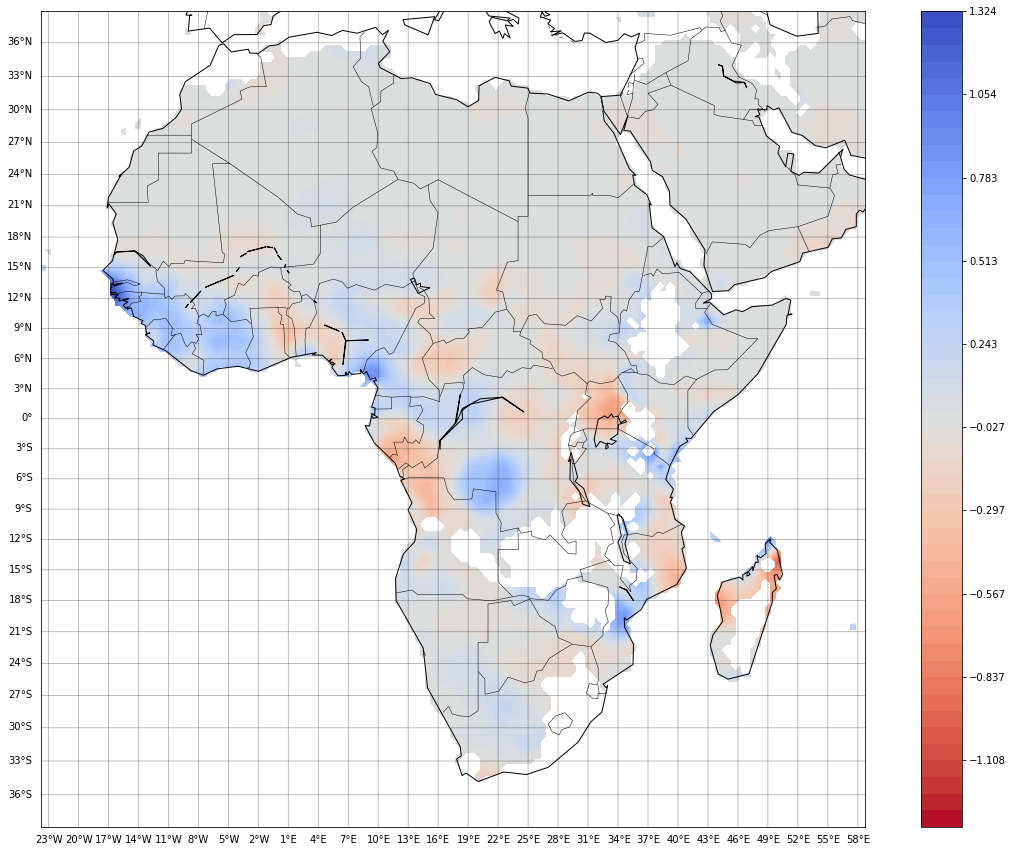

In [128]:
m=Basemap(projection='mill',lat_ts=50,llcrnrlon=lons.min(), \
  urcrnrlon=lons.max(),llcrnrlat=lats.min(),urcrnrlat=lats.max(), \
  resolution='c')
#m = Basemap(projection='ortho',lat_0=0,lon_0=-180,resolution='l')

lon2, lat2 = np.meshgrid(lons,lats)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcoastlines()
m.drawcountries()

levels = np.linspace(vmin, vmax)
cs = m.contourf(x,y,deg,20, levels = levels, cmap=plt.cm.get_cmap('coolwarm_r'))
plt.colorbar();
#plt.title(' EOF {}'.format(pc), fontsize = 20)
#plt.savefig("Ditnace from {} within {}.png".format(class_name, class_name))

In [11]:
d = Data('./nc/cru_ts4.05.1901.2020.pre.dat.nc','pre',missing_value=9.96921e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lon = d.get_lon()
lat = d.get_lat()

index = np.where(result[0,:] != 9.96921e+36)[1]

result = result[:,index]
lon_list = np.array(lon_list)[index]
lat_list = np.array(lat_list)[index]

In [12]:
d = Data('./nc/cru_ts4.05.1901.2020.tmp.dat.nc','tmp', missing_value=9.96921e+36)

result_air = d.get_data()
lon_list_air = d.get_lon_list()
lat_list_air = d.get_lat_list()
lon_air = d.get_lon()
lat_air = d.get_lat()

index = np.where(result_air[0,:] != 9.96921e+36)[1]

result_air = result_air[:,index]
lon_list_air = np.array(lon_list_air)[index]
lat_list_air = np.array(lat_list_air)[index]

In [13]:
result.shape

(1440, 67420)

In [14]:
result_air.shape

(1440, 67420)

In [15]:
precipitation = result.copy()
temperature = result_air.copy()


precipitation, avgs_pre, stds_pre = deseasonalize_avg_std(precipitation)
temperature, avgs_temp, stds_temp = deseasonalize_avg_std(temperature)

In [16]:
avgs_pre = pd.DataFrame(avgs_pre)
avgs_air = pd.DataFrame(avgs_temp)

df = pd.DataFrame({"lons":lon_list,"lats":lat_list})

lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"] = lon_temp

s_index = (df["lats"] <= 0).values
n_index = (df["lats"] > 0).values

avgs_pre = southern_season(avgs_pre,s_index)
avgs_air = southern_season(avgs_temp,s_index)

#data = pd.concat([avgs_pre.transpose(),avgs_air.transpose()],ignore_index=True,sort=False, axis=0)

In [17]:
avgs_pre = pd.concat([avgs_pre.iloc[:,9:],avgs_pre.iloc[:,:9]],ignore_index=True,sort=False, axis=1)

In [18]:
avgs_air = pd.concat([avgs_air.iloc[:,9:],avgs_air.iloc[:,:9]],ignore_index=True,sort=False, axis=1)

In [19]:
data = pd.concat([avgs_pre.transpose(),avgs_air.transpose()],ignore_index=True,sort=False, axis=0)

In [20]:
data = data.transpose()

In [21]:
data

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,286.140839,177.799164,136.073334,99.060013,103.612503,145.448334,174.935837,258.080017,282.253326,305.632477,...,25.318335,24.664167,24.334167,24.895834,25.299999,26.201666,26.873331,27.076666,27.421667,26.945833
1,47.700832,45.965828,31.770000,34.014168,25.574165,25.651669,20.490000,17.215000,22.113335,43.599171,...,-18.485832,-20.221668,-20.713335,-19.028332,-12.740001,-3.156667,4.807500,9.005000,8.115833,3.479167
2,45.274170,45.288334,29.486666,31.868334,24.909168,24.085001,19.600000,16.580833,21.305836,42.912498,...,-19.184166,-21.021667,-21.506666,-19.830000,-13.550000,-3.660833,4.405000,8.501666,7.518333,2.978333
3,36.838333,42.014999,26.743336,29.362499,22.541666,23.468332,16.918333,15.996668,23.305000,45.211670,...,-20.575834,-22.316668,-23.014168,-21.732502,-15.560834,-5.465834,2.806667,6.807500,5.820000,1.486667
4,34.847500,41.191666,24.701666,27.549166,21.036665,21.580000,15.932500,15.407499,22.744167,44.294170,...,-21.268335,-23.100834,-23.918335,-22.533333,-16.462500,-6.057500,2.310833,6.113333,5.221666,0.882500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67415,34.700001,35.410835,20.489166,23.795834,16.911669,17.013334,19.075001,23.718332,29.063334,49.105000,...,-25.748331,-27.825832,-28.846666,-27.220833,-20.084167,-9.244167,-0.797500,2.842500,1.742500,-2.298333
67416,33.189999,34.349171,18.290833,22.616669,15.119166,16.019165,17.339169,22.070833,27.254168,47.023331,...,-26.125834,-28.385000,-29.344999,-27.621666,-20.474165,-9.537500,-0.984167,2.460833,1.445833,-2.590000
67417,32.669998,32.962502,17.564167,21.383333,14.087500,14.009166,14.585834,17.292501,22.490002,40.873333,...,-25.014166,-27.223331,-28.049166,-26.209167,-19.176668,-8.120833,0.633333,3.872500,2.759166,-1.180000
67418,6.982500,11.329166,19.576668,18.008333,12.110834,6.168334,5.429167,2.858333,12.128333,33.441666,...,-25.213335,-26.096668,-27.351667,-25.821667,-18.360003,-6.327500,3.785833,8.117499,6.590001,0.948333


In [27]:
climate = []
for i in range(data.shape[0]):
    pre = data.iloc[i,:12].values
    air = data.iloc[i,12:].values
    
    MAP = pre.sum()
    Pdry = pre.min()
    Pwinter = pre[:6].sum()
    Psummer = pre[6:].sum()
    Pwdry = Pwinter.min()
    Psdry = Psummer.min()
    Pwwet = Pwinter.max()
    Pswet = Psummer.max()


    MAT = air.mean()
    Tcold = air.min()
    Thot = air.max()
    Tmon10 = np.count_nonzero(air > 10)

    if Pwinter >= 0.7 * MAP:
        Pthresh = 2 * MAT
    elif Psummer >= 0.7 * MAP:
        Pthresh = 2 * MAT + 28 
    else:
        Pthresh = 2 * MAT + 14


    if Tcold >= 18:
        if Pdry >= 60:
            climate.append('Af')
            continue
        elif Pdry >= (100 - (MAP/25)):
            climate.append('Am')
            continue
        elif np.argmin(pre) < 6:
            climate.append('Aw')
            continue
        else:
            climate.append('As')
            continue
    elif MAP < 10 * Pthresh:
        if MAP < 5 * Pthresh:
            if MAT >= 18:
                climate.append('BWh')
                continue
            else:
                climate.append('BWk')
                continue
        else:
            if MAT >= 18:
                climate.append('BSh')
                continue
            else:
                climate.append('BSk')
                continue
    elif (Thot > 10) and (Tcold <18) and (Tcold > 0):
        if (Psdry < 40) and (Psdry < Pwwet/3):
            climate.append('Cs{}'.format(Ctype(Thot, Tmon10)))
            continue            
        elif Pwdry < Pswet/10:
            climate.append('Cw{}'.format(Ctype(Thot, Tmon10)))
            continue  
        else:
            climate.append('Cf{}'.format(Ctype(Thot, Tmon10)))
            continue  
    elif (Thot > 10) and (Tcold <=0):
        if (Psdry < 40) and (Psdry < Pwwet/3):
            climate.append('Ds{}'.format(Dtype(Thot, Tmon10, Tcold)))
            continue            
        elif Pwdry < Pswet/10:
            climate.append('Dw{}'.format(Dtype(Thot, Tmon10, Tcold)))
            continue  
        else:
            climate.append('Df{}'.format(Dtype(Thot, Tmon10, Tcold)))
            continue  
    elif Thot < 10:
        if Thot > 0:
            climate.append('ET')
        else:
            climate.append('EF')
    else:
        climate.append('NAN')

In [29]:
len(climate)

67420

In [31]:
df['class'] = climate

In [32]:
df

,lons,lats,class
0,-179.75,-16.25,Af
1,-179.75,65.25,ET
2,-179.75,65.75,ET
3,-179.75,66.25,ET
4,-179.75,66.75,ET
...,...,...,...
67415,179.75,67.75,ET
67416,179.75,68.25,ET
67417,179.75,68.75,ET
67418,179.75,70.75,ET


In [51]:
with open('koppen_class.pickle', 'wb') as handle:
    pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
dic = {}
for i in range(df.shape[0]):
    dic[(df.iloc[i,1],df.iloc[i,0])] = df.iloc[i,2]

In [50]:
dic[(68.25, -179.25)]

'ET'

In [47]:
class_dic

{(-89.75, -179.75): 'EF',
 (-89.75, -179.25): 'EF',
 (-89.75, -178.75): 'EF',
 (-89.75, -178.25): 'EF',
 (-89.75, -177.75): 'EF',
 (-89.75, -177.25): 'EF',
 (-89.75, -176.75): 'EF',
 (-89.75, -176.25): 'EF',
 (-89.75, -175.75): 'EF',
 (-89.75, -175.25): 'EF',
 (-89.75, -174.75): 'EF',
 (-89.75, -174.25): 'EF',
 (-89.75, -173.75): 'EF',
 (-89.75, -173.25): 'EF',
 (-89.75, -172.75): 'EF',
 (-89.75, -172.25): 'EF',
 (-89.75, -171.75): 'EF',
 (-89.75, -171.25): 'EF',
 (-89.75, -170.75): 'EF',
 (-89.75, -170.25): 'EF',
 (-89.75, -169.75): 'EF',
 (-89.75, -169.25): 'EF',
 (-89.75, -168.75): 'EF',
 (-89.75, -168.25): 'EF',
 (-89.75, -167.75): 'EF',
 (-89.75, -167.25): 'EF',
 (-89.75, -166.75): 'EF',
 (-89.75, -166.25): 'EF',
 (-89.75, -165.75): 'EF',
 (-89.75, -165.25): 'EF',
 (-89.75, -164.75): 'EF',
 (-89.75, -164.25): 'EF',
 (-89.75, -163.75): 'EF',
 (-89.75, -163.25): 'EF',
 (-89.75, -162.75): 'EF',
 (-89.75, -162.25): 'EF',
 (-89.75, -161.75): 'EF',
 (-89.75, -161.25): 'EF',
 (-89.75, -1

In [53]:
pre = data.iloc[0,:12].values
air = data.iloc[0,12:].values

In [57]:
pre

array([174.93583679, 258.08001709, 282.25332642, 305.63247681,
       285.85998535, 314.10250854, 286.14083862, 177.79916382,
       136.07333374,  99.06001282, 103.61250305, 145.44833374])

In [60]:
pre[:6].sum()

1620.8641510009766

12

In [74]:
climate = []

MAP = pre.sum()
Pdry = pre.min()
Pwinter = pre[:6].sum()
Psummer = pre[6:].sum()
Pwdry = Pwinter.min()
Psdry = Psummer.min()
Pwwet = Pwinter.max()
Pswet = Psummer.max()


MAT = air.mean()
Tcold = air.min()
Thot = air.max()
Tmon10 = np.count_nonzero(air > 10)

if Pwinter >= 0.7 * MAP:
    Pthresh = 2 * MAT
elif Psummer >= 0.7 * MAP:
    Pthresh = 2 * MAT + 28 
else:
    Pthresh = 2 * MAT + 14


if Tcold >= 18:
    if Pdry >= 60:
        climate.append('Af')
        continue
    elif Pdry >= (100 - (MAP/25)):
        climate.append('Am')
        continue
    elif np.argmin(pre) < 6:
        climate.append('Aw')
        continue
    else:
        climate.append('As')
        continue
elif MAP < 10 * Pthresh:
    if MAP < 5 * Pthresh:
        if MAT >= 18:
            climate.append('BWh')
            continue
        else:
            climate.append('BWk')
            continue
    else:
        if MAT >= 18:
            climate.append('BSh')
            continue
        else:
            climate.append('BSk')
            continue
elif (Thot > 10) and (Tcold <18) and (Tcold > 0):
    if (Psdry < 40) and (Psdry < Pwwet/3):
        climate.append('Cs{}'.format(Ctype(Thot, Tmon10)))
        continue            
    elif Pwdry < Pswet/10:
        climate.append('Cw{}'.format(Ctype(Thot, Tmon10)))
        continue  
    else:
        climate.append('Cf{}'.format(Ctype(Thot, Tmon10)))
        continue  
elif (Thot > 10) and (Tcold <=0):
    if (Psdry < 40) and (Psdry < Pwwet/3):
        climate.append('Ds{}'.format(Dtype(Thot, Tmon10, Tcold)))
        continue            
    elif Pwdry < Pswet/10:
        climate.append('Dw{}'.format(Dtype(Thot, Tmon10, Tcold)))
        continue  
    else:
        climate.append('Df{}'.format(Dtype(Thot, Tmon10, Tcold)))
        continue  
elif Thot < 10:
    if Thot > 0:
        climate.append('ET')
    else:
        climate.append('EF')

SyntaxError: 'continue' not properly in loop (<ipython-input-74-0d50a2996bbf>, line 29)

In [72]:
def Ctype(Thot, Tmon10):
    if Thot >= 22:
        return('a')
    elif Tmon10 >= 4:
        return('b')
    elif (Tmon10 >= 1) and (Tmon10 < 4):
        return('c')

In [73]:
def Dtype(Thot, Tmon10, Tcold):
    if Thot >= 22:
        return('a')
    elif Tmon10 >= 4:
        return('b')
    elif (Tcold < -38):
        return('d')
    else:
        return('c')

In [66]:
if Thot >= 22:
    climate.append('Csa')
    continue            
elif Tmon10 >= 4:
    climate.append('Csb')
    continue 
elif (Tmon10 >= 1) and (Tmon10 < 4):
    climate.append('Csc')
    continue 

In [67]:
a < b/3

True